# Testing LLaVA Model on RTX 4060 (8GB VRAM) - Fixed Version 12

In [1]:
import torch
import gc
from transformers import LlavaNextProcessor, LlavaNextForConditionalGeneration, BitsAndBytesConfig
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import json
import os
import re
from huggingface_hub import notebook_login

# Clear any existing cached memory
gc.collect()
torch.cuda.empty_cache()

# Enable memory optimizations
torch.backends.cuda.enable_mem_efficient_sdp(True)
torch.set_float32_matmul_precision('medium')

In [ ]:
# Login to Hugging Face
notebook_login()

In [2]:
# Load processor and model
processor = LlavaNextProcessor.from_pretrained("Declan1/llava-v1.6-mistral-7b-sydneyfish-a100")

print("Loading quantized model for RTX 4060...")
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True
)

model = LlavaNextForConditionalGeneration.from_pretrained(
    "Declan1/llava-v1.6-mistral-7b-sydneyfish-a100",
    quantization_config=quantization_config,
    device_map="auto",
    torch_dtype=torch.float16,
    offload_folder="offload",
    max_memory={0: "6GB", "cpu": "16GB"}
)

Loading quantized model for RTX 4060...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [3]:
def get_images_from_folder(data_dir, test_ratio=0.5, seed=42):
    """Get images and their true labels from species folders"""
    import random
    random.seed(seed)
    
    images = []
    labels = []
    image_paths = []
    
    # Get all species folders
    species_folders = [f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))]
    print(f"\nFound species folders: {species_folders}")
    
    for species_folder in species_folders:
        species_path = os.path.join(data_dir, species_folder)
        image_files = [f for f in os.listdir(species_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        print(f"\n{species_folder} - Found {len(image_files)} images")
        
        # Randomly select test_ratio percentage of images
        num_images = max(1, int(len(image_files) * test_ratio))
        selected_images = random.sample(image_files, num_images)
        
        print(f"Selected {len(selected_images)} images for test set")
        
        for img_file in selected_images:
            img_path = os.path.join(species_path, img_file)
            print(f"  Loading {img_path}")
            
            try:
                # Load and verify image
                image = Image.open(img_path).convert('RGB')
                images.append(image)
                # Use folder name as species label
                labels.append(species_folder.replace('_', ' '))
                image_paths.append(img_path)
            except Exception as e:
                print(f"ERROR loading {img_path}: {str(e)}")
    
    return images, labels, image_paths

In [4]:
def extract_species_name(text):
    """Extract species name from model output"""
    # Try to find species name in XML-style tags
    match = re.search(r'<s_name>(.*?)</s_name>', text)
    if match:
        return match.group(1)
    
    # If no XML tags, try to extract from plain text response
    # Remove [INST] and other tags
    text = re.sub(r'\[INST\].*?\[/INST\]', '', text)
    text = re.sub(r'<.*?>', '', text)
    return text.strip()

In [5]:
def test_model(data_dir="data-fish-test", test_ratio=0.5):
    """Test model on fish images"""
    model.eval()
    predictions = []
    targets = []
    test_images = []
    
    # Load test images
    images, labels, image_paths = get_images_from_folder(data_dir, test_ratio)
    print(f"Test samples: {len(images)}")
    
    # Open predictions log file
    with open('predictions_log.txt', 'w') as log_file:
        with torch.no_grad():
            for idx, (image, true_label, img_path) in enumerate(zip(images, labels, image_paths)):
                # Clear cache between samples
                torch.cuda.empty_cache()
                
                # Store original image
                test_images.append(np.array(image))
                targets.append(true_label)
                
                try:
                    # Prepare input
                    prompt = f"[INST] <image>\nWhat species of fish is this? [/INST]"
                    inputs = processor(prompt, image, return_tensors="pt").to("cuda:0")
                    
                    # Generate prediction
                    outputs = model.generate(
                        **inputs,
                        max_new_tokens=128,
                        pad_token_id=processor.tokenizer.pad_token_id,
                        eos_token_id=processor.tokenizer.eos_token_id
                    )
                    
                    # Process prediction
                    pred_text = processor.decode(outputs[0], skip_special_tokens=True)
                    pred_species = extract_species_name(pred_text)
                    predictions.append(pred_species)
                    
                    # Log prediction
                    log_entry = f"Prediction {idx}:\nImage: {img_path}\nPredicted: {pred_species}\nActual: {true_label}\n{'='*50}\n"
                    log_file.write(log_entry)
                    log_file.flush()
                    
                except Exception as e:
                    print(f"Error processing sample {idx}: {str(e)}")
                    predictions.append("ERROR")
                    continue
                finally:
                    # Clear GPU memory
                    if 'outputs' in locals():
                        del outputs
                    if 'inputs' in locals():
                        del inputs
                    torch.cuda.empty_cache()
                
                if idx % 10 == 0:
                    print(f"Processed {idx}/{len(images)} samples")
    
    return predictions, targets, test_images

In [6]:
# Run testing
predictions, targets, test_images = test_model()

You may have used the wrong order for inputs. `images` should be passed before `text`. The `images` and `text` inputs will be swapped. This behavior will be deprecated in transformers v4.47.
Expanding inputs for image tokens in LLaVa-NeXT should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.47.



Found species folders: ['test']

test - Found 3 images
Selected 1 images for test set
  Loading data-fish-test\test\frame_803.jpg
Test samples: 1


Expanding inputs for image tokens in LLaVa-NeXT should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.47.


Processed 0/1 samples


In [7]:
def analyze_results(predictions, targets, test_images):
    """Analyze and visualize results"""
    correct_indices = []
    incorrect_indices = []
    
    for i, (pred, target) in enumerate(zip(predictions, targets)):
        if pred.lower() == target.lower():
            correct_indices.append(i)
        else:
            incorrect_indices.append(i)
    
    # Print overall statistics
    accuracy = len(correct_indices) / len(predictions)
    print(f"\nTest Results:")
    print(f"Total samples: {len(predictions)}")
    print(f"Correct predictions: {len(correct_indices)}")
    print(f"Incorrect predictions: {len(incorrect_indices)}")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    
    # Show example correct predictions
    print("\nExample Correct Predictions:")
    for idx in correct_indices[:5]:
        print(f"\nTrue: {targets[idx]}")
        print(f"Predicted: {predictions[idx]}")
        plt.figure(figsize=(8, 8))
        plt.imshow(test_images[idx])
        plt.title(f"Correct: {predictions[idx]}")
        plt.axis('off')
        plt.show()
    
    # Show example incorrect predictions
    print("\nExample Incorrect Predictions:")
    for idx in incorrect_indices[:5]:
        print(f"\nTrue: {targets[idx]}")
        print(f"Predicted: {predictions[idx]}")
        plt.figure(figsize=(8, 8))
        plt.imshow(test_images[idx])
        plt.title(f"Incorrect - Predicted: {predictions[idx]}\nTrue: {targets[idx]}")
        plt.axis('off')
        plt.show()


Test Results:
Total samples: 1
Correct predictions: 0
Incorrect predictions: 1
Accuracy: 0.00%

Example Correct Predictions:

Example Incorrect Predictions:

True: test
Predicted: Pomatomus saltatrix


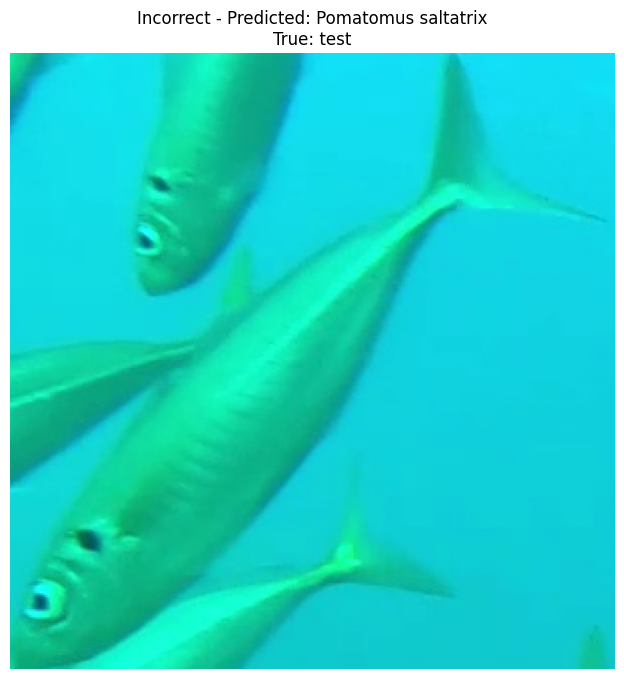

In [8]:
# Analyze results
analyze_results(predictions, targets, test_images)